# Predicting Seabird Diving Behaviour with GPS data

Supervized Learning with Complex Numbers

In [1]:
# mount google drive
from google.colab import drive
drive.mount("/content/drive/")

Mounted at /content/drive/


In [2]:
%cd drive/My\ Drive/BirdDL

/content/drive/My Drive/BirdDL


In [3]:
import sqlite3
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import IPython
import datetime
import random
import pickle
import trip

In [4]:
# connect to database
conn = sqlite3.connect('/content/drive/My Drive/data/seabirdbank.db')
# conn = sqlite3.connect('/home/amdroy/MEGA/DATA/seabirdbank.db')

In [5]:
request = "SELECT \
            trip.id as trip, gps.datetime, gps.lon, gps.lat\
            FROM gps \
            INNER JOIN trip ON gps.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# substr(bird.fieldwork,1,1) = 'P'

gps = pd.read_sql_query(request, conn)

# check duplicated datetime in GPS trip
idx = gps.index[gps.loc[:, 'trip':'datetime'].duplicated(keep=False)]
idx_drop = [idx[i] for i in range(0, len(idx), 2)]
gps = gps.drop(idx_drop)


request = "SELECT \
            trip.id as trip, tdr.datetime, tdr.pressure \
            FROM tdr \
            INNER JOIN trip ON tdr.trip = trip.id \
            INNER JOIN bird ON trip.bird = bird.id \
            WHERE trip.file_gps IS NOT NULL \
            AND trip.file_tdr IS NOT NULL \
            AND (bird.fieldwork = 'P1108' OR bird.fieldwork = 'P1111' \
                OR bird.fieldwork = 'P1112' OR bird.fieldwork = 'P1113') \
            AND bird.species = 'SV'"

# WHERE substr(bird.fieldwork,1,1) = 'P' 

tdr = pd.read_sql_query(request, conn)
tdr['datetime'] = pd.to_datetime(tdr['datetime'], format='%Y-%m-%d %H:%M:%S')
gps['datetime'] = pd.to_datetime(gps['datetime'], format='%Y-%m-%d %H:%M:%S')

df = pd.merge(tdr, gps, on=['trip', 'datetime'], how='left')

# check NaN and fill with interpolations
[i for i, x in enumerate(df['lon'].isna()) if x]


df['lon'] = df['lon'].interpolate(method='polynomial', order=2)
df['lat'] = df['lat'].interpolate(method='polynomial', order=2)


bad_trip = ['P1111_9_SV_T1', 'P1111_13_SV_T6', 'P1111_41_SV_T2', 'P1111_46_SV_T5', 'P1111_52_SV_T1',
            'P1112_4_SV_T2', 'P1112_26_SV_T5', 'P1112_36_SV_T1', 'P1112_36_SV_T2', 'P1113_41_SV_T3',
           'P1113_50_SV_T2']

no_loop = ['P1112_26_SV_T1', 'P1112_26_SV_T2', 'P1112_26_SV_T3', 'P1112_26_SV_T4']


### remove bad data
idx = df.index[[(t in bad_trip or t in no_loop) for t in df.trip]]
df = df.drop(idx)

df

,trip,datetime,pressure,lon,lat
0,P1108_4_SV_T1,2008-11-25 13:00:35,-0.35,-77.264128,-11.773317
1,P1108_4_SV_T1,2008-11-25 13:00:36,-0.38,-77.264118,-11.773235
2,P1108_4_SV_T1,2008-11-25 13:00:37,-0.35,-77.264098,-11.773152
3,P1108_4_SV_T1,2008-11-25 13:00:38,-0.29,-77.264113,-11.773060
4,P1108_4_SV_T1,2008-11-25 13:00:39,-0.29,-77.264142,-11.772955
...,...,...,...,...,...
1035988,P1113_50_SV_T1,2013-11-24 13:09:17,-1.01,-77.264229,-11.773601
1035989,P1113_50_SV_T1,2013-11-24 13:09:18,-1.07,-77.264221,-11.773701
1035990,P1113_50_SV_T1,2013-11-24 13:09:19,-1.07,-77.264191,-11.773771
1035991,P1113_50_SV_T1,2013-11-24 13:09:20,-1.01,-77.264168,-11.773826


In [152]:
%%time
trajs = []
threshold = 1
radius = 500
n = 1
for k in df.trip.unique():
    df_trip = df[df.trip == k]
    
    t = trip.Trip(df_trip)

    # add variables
    t.add_dive(threshold)
    t.add_step()
    t.add_cap()
    t.df['speed_lon'] = np.cos(t.df.cap) * t.df.step
    t.df['speed_lat'] = np.sin(t.df.cap) * t.df.step

    # standardized trajectories
    t.standardize(('speed_lon', 'speed_lat'))
    t.standardize_minmax(('lon', 'lat'))
    
    trajs.append(t.df)
    
    IPython.display.clear_output(wait=True)
    print('Trip [{}/{}]'.format(n, len(df.trip.unique())))
    n+=1

Trip [170/170]
CPU times: user 20.3 s, sys: 306 ms, total: 20.6 s
Wall time: 20.6 s


In [153]:
test_trajs_idx = np.random.randint(0, len(df.trip.unique()), 30)

test_trajs = [trajs[i] for i in test_trajs_idx]
train_trajs = [trajs[i] for i in range(len(df.trip.unique())) if i not in test_trajs_idx]

## Neural Network

In [154]:
# pytorch materials
import torch
from torch import nn
from torch import optim
import torchvision as tv
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader

#### Complex CNN

In [155]:
class Sampler:
    def __init__(self, trajs, epoch_input, epoch_output, batch_size, input_var):
      # raw trajectories
      self.trajs = trajs
      self.n = len(trajs)
      # sample input specificities
      self.epoch_input = epoch_input
      self.epoch_output = epoch_output
      self.epoch_ratio = round(epoch_input/epoch_output)
      self.batch_size = batch_size
      self.input_var = input_var


    def sample(self):
      input_batch = []
      output_batch = []
      for i in range(self.batch_size):
        # look for a long trip
        dt = []
        while len(dt) < self.epoch_input :
            traj_idx = np.random.randint(self.n)
            dt = self.trajs[traj_idx]

        # select part of this trip
        epoch_idx = np.random.randint(2, len(dt)-self.epoch_input )

        list_input_trajs = []
        for (real, im) in self.input_var:
            input_trajs_ = dt.loc[epoch_idx:epoch_idx+self.epoch_input -1, (real, im)]
            list_input_trajs.append(np.array(input_trajs_))

        input_trajs = np.stack(list_input_trajs)

        output_trajs = dt.loc[epoch_idx:epoch_idx+self.epoch_input -1, 'dive']

        # change resolution
        output = [np.max(output_trajs[i:i+self.epoch_ratio+1]) for i in range(len(output_trajs)) if i%self.epoch_ratio==0]

        # add it to batch
        input_batch.append(input_trajs)
        output_batch.append(np.array(output))

      # convert to tensor
      input_batch = torch.FloatTensor(input_batch)
      output_batch = torch.FloatTensor(output_batch)

      return (input_batch.permute(0,3,1,2), output_batch)

In [157]:
# Hyperparameters
epoch_input = 600
epoch_output = 60
batch_size = 4
learning_rate = 0.01

input_var = [('lon_std_mm', 'lat_std_mm'), ('speed_lon_std', 'speed_lat_std')]

train = Sampler(train_trajs, epoch_input, epoch_output, batch_size, input_var)
test = Sampler(test_trajs, epoch_input, epoch_output, batch_size, input_var)

(x, y) = train.sample()

x.size()

torch.Size([4, 2, 2, 600])

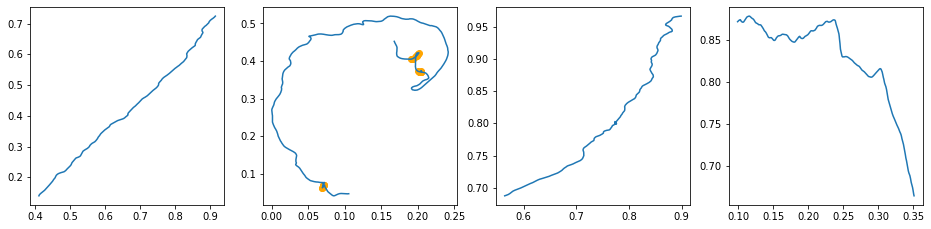

In [158]:
plt.figure(figsize=(16, 8))

for i in range(batch_size):
    lon = x.numpy()[i, 0, 0, :]
    lat = x.numpy()[i, 1, 0, :]

    real = y.numpy()[i,:]
    real = [real[i] for i in range(len(real)) for k in range(10) ]

    plt.subplot(2, 4, i+1)
    plt.plot(lon, lat)
    plt.scatter(lon[np.where(real)], lat[np.where(real)], c='orange')

In [159]:
### COMPLEX CNN

class ComplexConv2d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(ComplexConv2d,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.padding = padding

        ## Model components
        self.conv_re = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.conv_im = nn.Conv2d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        
    def forward(self, x): # shpae of x : [batch,2,channel,axis1,axis2]
        real = self.conv_re(x[:,0]) - self.conv_im(x[:,1])
        imaginary = self.conv_re(x[:,1]) + self.conv_im(x[:,0])
        output = torch.stack((real,imaginary),dim=1)
        return output

class ComplexConv1d(nn.Module):
    def __init__(self, in_channel, out_channel, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True):
        super(ComplexConv1d,self).__init__()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.padding = padding

        ## Model components
        self.conv_re = nn.Conv1d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        self.conv_im = nn.Conv1d(in_channel, out_channel, kernel_size, stride=stride, padding=padding, dilation=dilation, groups=groups, bias=bias)
        
    def forward(self, x): # shpae of x : [batch,2,channel,axis1,axis2]
        real = self.conv_re(x[:,0]) - self.conv_im(x[:,1])
        imaginary = self.conv_re(x[:,1]) + self.conv_im(x[:,0])
        output = torch.stack((real,imaginary),dim=1)
        return output

In [184]:
class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        
        self.cnn_input_1 = nn.Sequential(
            ComplexConv1d(2, 4, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            ComplexConv1d(4, 4, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_1 = nn.Sequential(
            nn.MaxPool2d(kernel_size = (1, 11), stride = (1, 2), padding = (0, 5), dilation =(1, 1))
        )

        self.cnn_input_2 = nn.Sequential(
            ComplexConv1d(4, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            ComplexConv1d(8, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_2 = nn.Sequential(
            nn.MaxPool2d(kernel_size = (1, 11), stride = (1, 2), padding = (0, 5), dilation =(1, 1))
        )

        self.cnn_input_3 = nn.Sequential(
            ComplexConv1d(8, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            ComplexConv1d(16, 16, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU()
        )

        self.pooling_3 = nn.Sequential(
            nn.MaxPool2d(kernel_size = (1, 11), stride = (1, 2), padding = (0, 5), dilation =(1, 4))
        )

        self.cnn_4 = nn.Sequential(
            ComplexConv1d(16, 8, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            ComplexConv1d(8, 4, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.ReLU(),
            ComplexConv1d(4, 1, kernel_size = 11, stride = 1, padding = 5, dilation = 1),
            nn.Sigmoid()
        )

                
    def forward(self, x):
        out = self.cnn_input_1(x)
        out = self.pooling_1(out)
        out = self.cnn_input_2(out)
        out = self.pooling_2(out)
        out = self.cnn_input_3(out)
        out = self.pooling_3(out)
        out = self.cnn_4(out)

        out = torch.square(out)
        out = torch.sum(out, dim = 1)

        return out.reshape((batch_size, epoch_output))

In [185]:
model = ConvNet()
out = model(x)
out.size()

torch.Size([4, 60])

In [186]:
# Loss and optimizer
criterion = nn.BCELoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

In [187]:
criterion(out, y)

tensor(0.5587, grad_fn=<BinaryCrossEntropyBackward>)

In [189]:
## estimate a relevant nb of total step
test_step = 100
total_step = 50000

In [191]:
# Train the model
list_score =[]
list_loss = []
for i in range(total_step):
    
    # Train the model
    model.train()
    (x,y) = train.sample() 
    # x, y = x.to(device), y.to(device)

    # Run the forward pass
    out = model(x)
    loss = criterion(out, y)

    # Backprop and perform optimisation
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    

    if (i + 1) % 1000 == 0:  
        # Test the model
        model.eval()
        with torch.no_grad():
            real = []
            estim = []
            for k in range(test_step):
                (x,y) = test.sample()
                # x, y = x.to(device), y.to(device)
                out = model(x)
                
                # dive prediction
                real.append( y.cpu().reshape(batch_size*epoch_output).detach().numpy() )
                estim.append( out.cpu().reshape(batch_size*epoch_output).detach().numpy() )

            real = np.hstack(real)
            estim = np.hstack(estim)

            # no dive prediction performance
            no_dive_prediction = [estim[i] for i in range(estim.shape[0]) if not real[i]]
            true_no_dive = 1-np.sum(no_dive_prediction)/len(no_dive_prediction)

            # dive prediction performance
            dive_prediction = [estim[i] for i in range(estim.shape[0]) if real[i]]
            true_dive = np.sum(dive_prediction)/len(dive_prediction)
        
            score = (true_no_dive + true_dive)/2

            list_loss.append(loss.item())
            list_score.append(score)


        print('Step [{}/{}], Loss: {:.4f}, Accuracy: {} %'
              .format(i + 1, total_step, loss.item(), score*100))

Step [1000/50000], Loss: 0.2516, Accuracy: 50.45231769998384 %
Step [2000/50000], Loss: 0.3195, Accuracy: 51.61751315277727 %
Step [3000/50000], Loss: 0.0966, Accuracy: 52.44986207813949 %
Step [4000/50000], Loss: 0.1933, Accuracy: 53.31126579144504 %
Step [5000/50000], Loss: 0.2402, Accuracy: 52.27932932998305 %
Step [6000/50000], Loss: 0.2164, Accuracy: 54.006049300051515 %
Step [7000/50000], Loss: 0.2611, Accuracy: 54.05325827258955 %
Step [8000/50000], Loss: 0.2118, Accuracy: 53.98511030838639 %
Step [9000/50000], Loss: 0.0837, Accuracy: 54.0052204692536 %
Step [10000/50000], Loss: 0.1109, Accuracy: 54.19612658150401 %
Step [11000/50000], Loss: 0.1327, Accuracy: 54.1396230702339 %
Step [12000/50000], Loss: 0.1192, Accuracy: 54.1665077626149 %
Step [13000/50000], Loss: 0.2048, Accuracy: 54.40282215550578 %
Step [14000/50000], Loss: 0.1563, Accuracy: 54.40167494814572 %
Step [15000/50000], Loss: 0.1225, Accuracy: 54.20424200077577 %
Step [16000/50000], Loss: 0.0992, Accuracy: 54.9484

KeyboardInterrupt: ignored